# 1. beispiel-  iso forest for anomaly detection (without timestamp)

## load data 

In [1]:
# load new datset
import pandas as pd
import numpy as np
full_df=pd.read_csv('https://raw.githubusercontent.com/numenta/NAB/master/data/realAWSCloudwatch/ec2_cpu_utilization_5f5533.csv')

df= full_df
full_df.dtypes
df.head()

,timestamp,value
0,2014-02-14 14:27:00,51.846
1,2014-02-14 14:32:00,44.508
2,2014-02-14 14:37:00,41.244
3,2014-02-14 14:42:00,48.568
4,2014-02-14 14:47:00,46.714


In [2]:
from datetime import datetime

datetime_str = '2018-12-18 13:55:26'



datetime_object = datetime.strptime(datetime_str, '%Y-%m-%d %H:%M:%S')

# add 000 as string to pandas dataframe
data = "000"
df_date = pd.DataFrame(  [x.split(';') for x in data.split('\n')])
print(df_date)

     0
0  000


In [3]:
# Using graph_objects
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import matplotlib.pyplot as plt
from matplotlib import pyplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import plotly.graph_objs as go


def plot_anomaly(df,metric_name):
    #df.timestamp = pd.to_datetime(df['timestamp'].astype(str), format="%Y-%m-%d %H:%M:%S")
    #df.timestamp = pd.to_datetime(df['timestamp'].astype(str), format="%d/%m/%Y")
    dates = df.index   #df.timestamp
    #identify the anomaly points and create a array of its values for plot
    bool_array = (abs(df['anomaly']) > 0)
    actuals = df["value"][-len(bool_array):]
    anomaly_points = bool_array * actuals
    anomaly_points[anomaly_points == 0] = np.nan
    #A dictionary for conditional format table based on anomaly
    color_map = {0: "blue", 1: "red"}
#Table which includes Date,Actuals,Change occured from previous point
    table = go.Table(
    domain=dict(x=[0, 1],
                y=[0, 0.3]),
    columnwidth=[1, 2],
    # columnorder=[0, 1, 2,],
    header=dict(height=20,
                values=[['<b>Date</b>'], ['<b>Actual Values </b>'],
                        ],
                font=dict(color=['rgb(45, 45, 45)'] * 5, size=14),
                fill=dict(color='#d562be'
                
                )),
    cells=dict(values=[df.round(3)[k].tolist() for k in ['timestamp', 'value']],
               line=dict(color='#506784'),
               align=['center'] * 5,
               font=dict(color=['rgb(40, 40, 40)'] * 5, size=12),
               # format = [None] + [",.4f"] + [',.4f'],
               # suffix=[None] * 4,
               suffix=[None] + [''] + [''] + ['%'] + [''],
               height=27,
               fill=dict(color=[df['anomaly'].map(color_map)],#map based on anomaly level from dictionary
               )
               ))
    #Plot the actuals points
    Actuals = go.Scatter(name='Actuals',
                     x=dates,
                     y=df['value'],
                     xaxis='x1', yaxis='y1',
                     mode='lines',
                     marker=dict(size=12,
                                 line=dict(width=1),
                                 color="blue"))
    #Highlight the anomaly points
    anomalies_map = go.Scatter(name="Anomaly",
                               showlegend=True,
                               x=dates,
                               y=anomaly_points,
                               mode='markers',
                               xaxis='x1',
                               yaxis='y1',
                               marker=dict(color="red",
                                           size=11,
                                           line=dict(
                                               color="red",
                                               width=2)))
    axis = dict(
        showline=True,
        zeroline=False,
        showgrid=True,
        mirror=True,
        ticklen=4,
        gridcolor='#ffffff',
        tickfont=dict(size=10))
    layout = dict(
        width=1000,
        height=865,
        autosize=False,
        title=metric_name,
        margin=dict(t=75),
        showlegend=True,
        xaxis1=dict(axis, **dict(domain=[0, 1], anchor='y1', showticklabels=True)),
        yaxis1=dict(axis, **dict(domain=[2 * 0.21 + 0.20, 1], anchor='x1', hoverformat='.2f')))
    fig = go.Figure(data=[table, anomalies_map, Actuals], layout=layout)
    iplot(fig)
    pyplot.show()

In [4]:

from sklearn.ensemble import IsolationForest
#to_model_column='value'
clf=IsolationForest(n_estimators=10, max_samples='auto', contamination=float(.04)) # cotamination boudary, how many should be outliners
                       # max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0,behaviour='new')
clf.fit(df[['value']])
df['scores']=clf.decision_function(df[['value']])
df['anomaly']=clf.fit_predict(df[['value']])
df.head()
df.loc[df['anomaly'] == 1,'anomaly'] = 0
df.loc[df['anomaly'] == -1,'anomaly'] = 1
#df.value_counts()
df['anomaly'].value_counts()


#plot the grapgh with anomalies
plot_anomaly(df,'anomalies')  


# 2. beispiel: ConvolutionSmoother ->Generate smoth signal and sigma distribution for input to detect outliners

https://github.com/cerlymarco/MEDIUM_NoteBook/blob/master/Anomaly_Detection_RealTime/Anomaly_Detection_RealTime.ipynb

https://pypi.org/project/tsmoothie/


## load data

In [5]:
# load new datset
import pandas as pd
import numpy as np
full_df=pd.read_csv('https://raw.githubusercontent.com/numenta/NAB/master/data/realAWSCloudwatch/ec2_cpu_utilization_5f5533.csv')

df= full_df
#full_df.dtypes
#df.shape

df.head()

,timestamp,value
0,2014-02-14 14:27:00,51.846
1,2014-02-14 14:32:00,44.508
2,2014-02-14 14:37:00,41.244
3,2014-02-14 14:42:00,48.568
4,2014-02-14 14:47:00,46.714


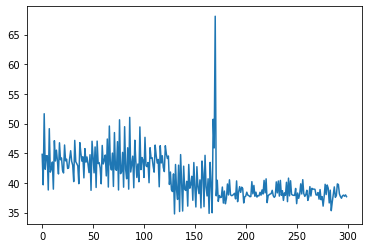

In [7]:
n_series, timesteps = 1, len(df['value'][2800:3100].values)
window_len = 20

#data_old = sim_randomwalk(n_series=n_series, timesteps=timesteps, 
 #                    process_noise=10, measure_noise=30)


# choose sigma value to dnymcly set outline thresholds

sigma=2

data=df['value'][2800:3100].values
#data.shape

plt.plot(data)
np.set_printoptions(False)



# prep for input signal prepocessing

#reshape it to prep for input
data
data_np_np=np.array(data)
data_np_np.shape
#data_np_np.reshape(2016,1)
dshaped=data_np_np.reshape(len(data_np_np),-1)
data_np_np.shape


#tranpsose it for input
dshaped.shape
datashapedTrans=np.transpose(dshaped)
datashapedTrans.shape


data=datashapedTrans

#data

In [191]:
#plt.plot(data_old.T)
#np.set_printoptions(False)
#datashapedTrans

In [186]:
#pd_data=pd.DataFrame(data.T)
#pd_data.shape
#data[[1]]
#data_old

#data_old_np=np.array(data_old)
#data_old_np.shape
#data_old_np

(300,)

In [8]:
def plot_history(ax, i, is_anomaly, window_len, color='blue', **pltargs):
    
    posrange = np.arange(0,i)
    
    ax.fill_between(posrange[window_len:], 
                    pltargs['low'][1:], pltargs['up'][1:], 
                    color=color, alpha=0.2)
    if is_anomaly:
        ax.scatter(i-1, pltargs['original'][-1], c='red')
    else:
        ax.scatter(i-1, pltargs['original'][-1], c='black')
    ax.scatter(i-1, pltargs['smooth'][-1], c=color)
    
    ax.plot(posrange, pltargs['original'][1:], '.k')
    ax.plot(posrange[window_len:], 
            pltargs['smooth'][1:], color=color, linewidth=3)
    
    if 'ano_id' in pltargs.keys():
        if pltargs['ano_id'].sum()>0:
            not_zeros = pltargs['ano_id'][pltargs['ano_id']!=0] -1
            ax.scatter(not_zeros, pltargs['original'][1:][not_zeros], 
                       c='red', alpha=1.)

In [9]:
### SIMULATE PROCESS REAL-TIME AND CREATE GIF ###



import numpy as np
import matplotlib.pyplot as plt
from celluloid import Camera
from collections import defaultdict
from functools import partial
from tqdm import tqdm

from tsmoothie.utils_func import sim_randomwalk, sim_seasonal_data
from tsmoothie.smoother import *




#fig = plt.figure(figsize=(18,10))
#camera = Camera(fig)

#axes = [plt.subplot(n_series,1,ax+1) for ax in range(n_series)]
series = defaultdict(partial(np.ndarray, shape=(n_series,1), dtype='float32'))

for i in tqdm(range(timesteps+1), total=(timesteps+1)):
    
    if i>window_len:
    
    # algorithm convo smoother
        smoother = ConvolutionSmoother(window_len=window_len, window_type='ones')
        smoother.smooth(series['original'][:,-window_len:])

        series['smooth'] = np.hstack([series['smooth'], smoother.smooth_data[:,[-1]]]) 

# choose sigma value to dnymcly set outline thresholds
        _low, _up = smoother.get_intervals('sigma_interval', n_sigma=sigma)
        series['low'] = np.hstack([series['low'], _low[:,[-1]]])
        series['up'] = np.hstack([series['up'], _up[:,[-1]]])

        is_anomaly = np.logical_or(
            series['original'][:,-1] > series['up'][:,-1], 
            series['original'][:,-1] < series['low'][:,-1]
        ).reshape(-1,1)
        
        if is_anomaly.any():
            series['ano_id'] = np.hstack([series['ano_id'], is_anomaly*i]).astype(int)
            
        for s in range(n_series):
            pltargs = {k:v[s,:] for k,v in series.items()}
            #plot_history(axes[s], i, is_anomaly[s], window_len, 
                      #   **pltargs)

        #camera.snap()
        
    if i>=timesteps:
        continue
    
    series['original'] = np.hstack([series['original'], data[:,[i]]])
    #series['original'] = np.hstack([series['original'], data[[i]]])

    
#print('CREATING GIF...')  # it may take a few seconds
#camera._photos = [camera._photos[-1]] + camera._photos
#animation = camera.animate()
#animation.save('animation1.gif')
#plt.close(fig)
#print('DONE')

100%|██████████| 301/301 [00:00<00:00, 1953.06it/s]


## plot the results of original signal, smotthed signal, boundaries for sigma=2  and outliners

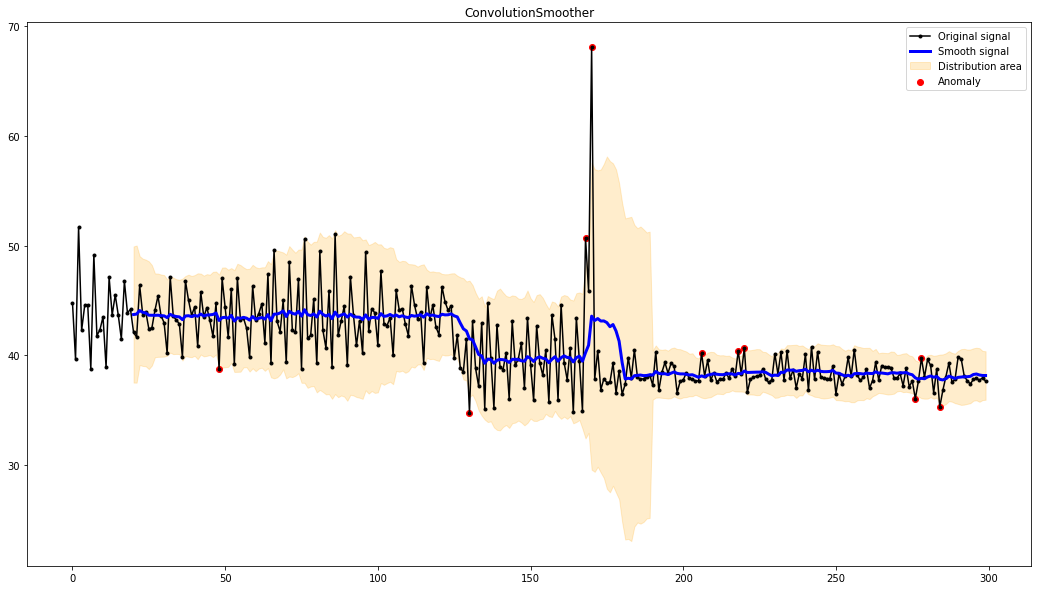

In [27]:

### PLOT FINAL RESULT ###

fig = plt.figure(figsize=(18,10))
axes = [plt.subplot(n_series,1,ax+1) for ax in range(n_series)]

for i,ax in enumerate(axes):
    
    posrange = np.arange(window_len,timesteps)
    
    ax.plot(series['original'][i,1:], '.k', c="black", linestyle="-", label="Original signal")
    ax.plot(posrange, series['smooth'][i,1:], c='blue', linewidth=3, label="Smooth signal")
    
    ax.fill_between(posrange, 
                    series['low'][i,1:], series['up'][i,1:], 
                    color='orange', alpha=0.2, label="Distribution area")
    
    ano_id = series['ano_id'][i][series['ano_id'][i] != 0] -1
    
    if len(ano_id)>0:
        ax.scatter( ano_id, series['original'][i,1:][ano_id], 
                   c='red', alpha=1. ,  label="Anomaly")


plt.title("ConvolutionSmoother")
plt.legend() #series['original'],"gelb")                   

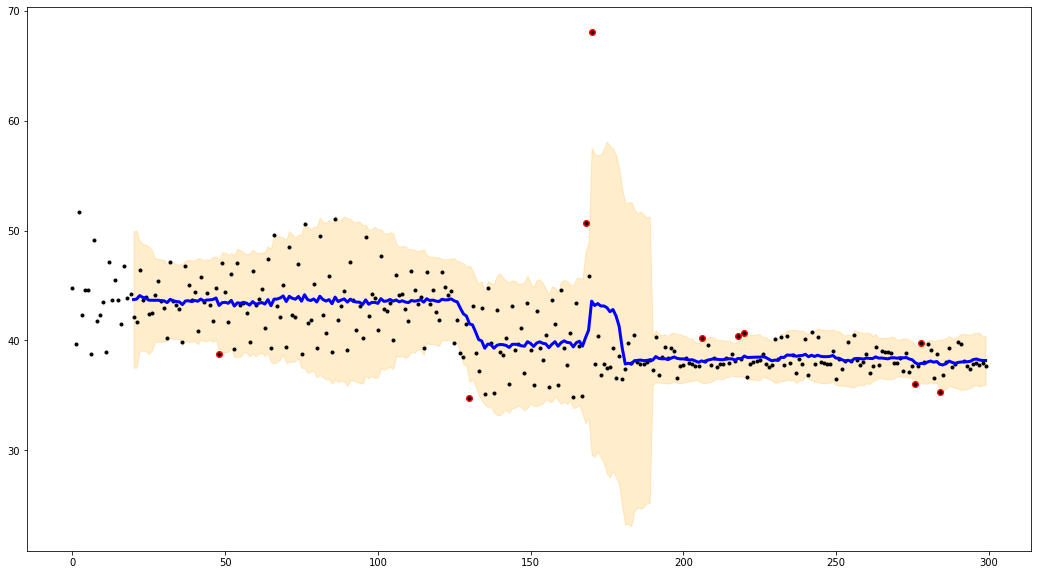

In [10]:
### PLOT FINAL RESULT ###

fig = plt.figure(figsize=(18,10))
axes = [plt.subplot(n_series,1,ax+1) for ax in range(n_series)]

for i,ax in enumerate(axes):
    
    posrange = np.arange(window_len,timesteps)
    
    ax.plot(series['original'][i,1:], '.k', c="black")
    ax.plot(posrange, series['smooth'][i,1:], c='blue', linewidth=3)
    
    ax.fill_between(posrange, 
                    series['low'][i,1:], series['up'][i,1:], 
                    color='orange', alpha=0.2)
    
    ano_id = series['ano_id'][i][series['ano_id'][i] != 0] -1
    
    if len(ano_id)>0:
        ax.scatter(ano_id, series['original'][i,1:][ano_id], 
                   c='red', alpha=1.)